In [25]:
import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup as bs
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

### Read in datasets

In [26]:
collections = pd.read_csv('collections.csv').drop(columns = ['Unnamed: 0'])
collections = collections.sort_values('designer').sort_values('seasonyear')
collections['id'] = collections.index
collections.head()

,season,year,seasonyear,designer,text,id,raw_tokens,preprocessed_sentences,consistency,prevalence,class
0,spring,1990,1990.0,azzedine-alaia,An enfilade of stretchy knits in jewel tones w...,0,"['An', 'enfilade', 'of', 'stretchy', 'knits', ...",enfilad stretchi knit jewel tone effect showma...,0.235294,0.172794,4
1,spring,1990,1990.0,romeo-gigli,Romeo Gigli is having a moment. The designer’s...,1,"['Romeo', 'Gigli', 'is', 'having', 'a', 'momen...",moment design signatur cocoon shape folder stu...,0.014706,-0.985294,0
2,fall,1990,1990.1,azzedine-alaia,Alaïa worked with pinstripes and other power m...,2,"['Alaïa', 'worked', 'with', 'pinstripes', 'and...",work pinstrip power materi season time spot re...,0.235294,0.172794,4
3,spring,1991,1991.0,azzedine-alaia,"<a href=""https://www.vogue.com/article/bella-h...",3,"['<', 'a', 'href=', ""''"", 'https', ':', '//www...",hadid remind follow timeless appeal april appe...,0.235294,0.172794,4
4,spring,1991,1991.0,comme-des-garcons,"“Comme des Garçons,” Rei Kawakubo told <em>Vog...",4,"['“', 'Comme', 'des', 'Garçons', ',', '”', 'Re...",told gift oneself appeal attract opposit sex s...,0.984848,0.969464,10


In [27]:
collections.shape

(14261, 11)

In [28]:
designers = pd.read_csv('designers.csv').drop(columns = ['Unnamed: 0'])
designers.head()

,designer,collections,first_season,consistency,prevalence,class
0,comme-des-garcons,65,1991.0,0.984848,0.969464,10
1,versace,61,1991.0,0.924242,0.907849,8
2,alexander-mcqueen,57,1995.0,0.982759,0.965215,10
3,prada,57,1992.0,0.890625,0.873081,8
4,miu-miu,55,1995.1,0.964912,0.946730,9


In [29]:
designers.shape

(1285, 6)

In [30]:
collections['tokens'] = [word_tokenize(sentence) for sentence in collections['preprocessed_sentences']]
sample_tokens = (collections[['id','tokens']].explode('tokens'))
sample_tokens.head()

,id,tokens
0,0,enfilad
0,0,stretchi
0,0,knit
0,0,jewel
0,0,tone


### Exploratory data analysis & visualizations

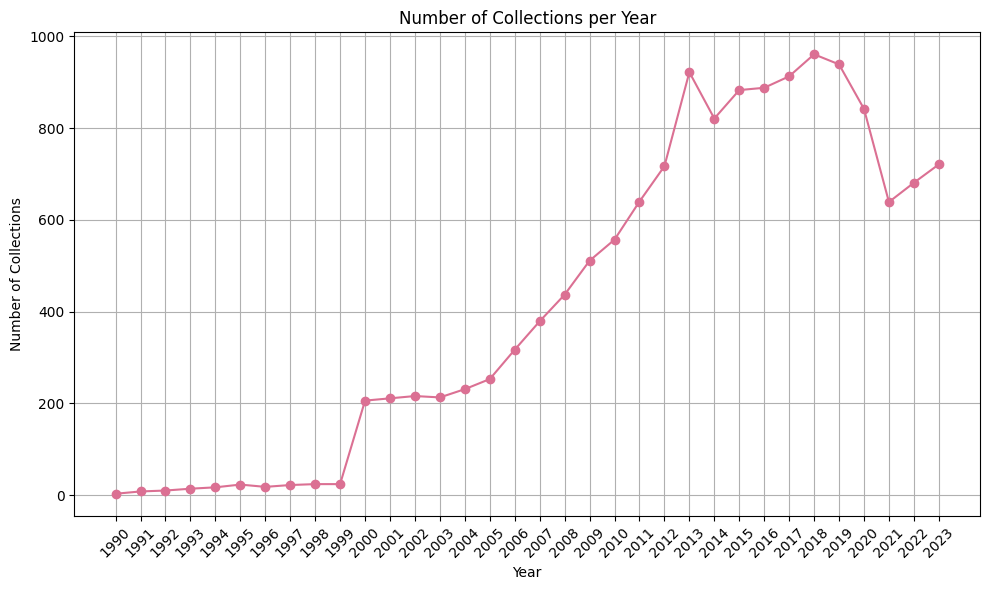

In [31]:
collections_per_year = collections.groupby(collections['year']).size()

# Plotting
plt.figure(figsize=(10, 6))
collections_per_year.plot(kind='line', marker='o', color='palevioletred')
plt.title('Number of Collections per Year')
plt.xlabel('Year')
plt.ylabel('Number of Collections')
plt.grid(True)
plt.xticks(collections_per_year.index, rotation=45)
plt.tight_layout()
plt.show()


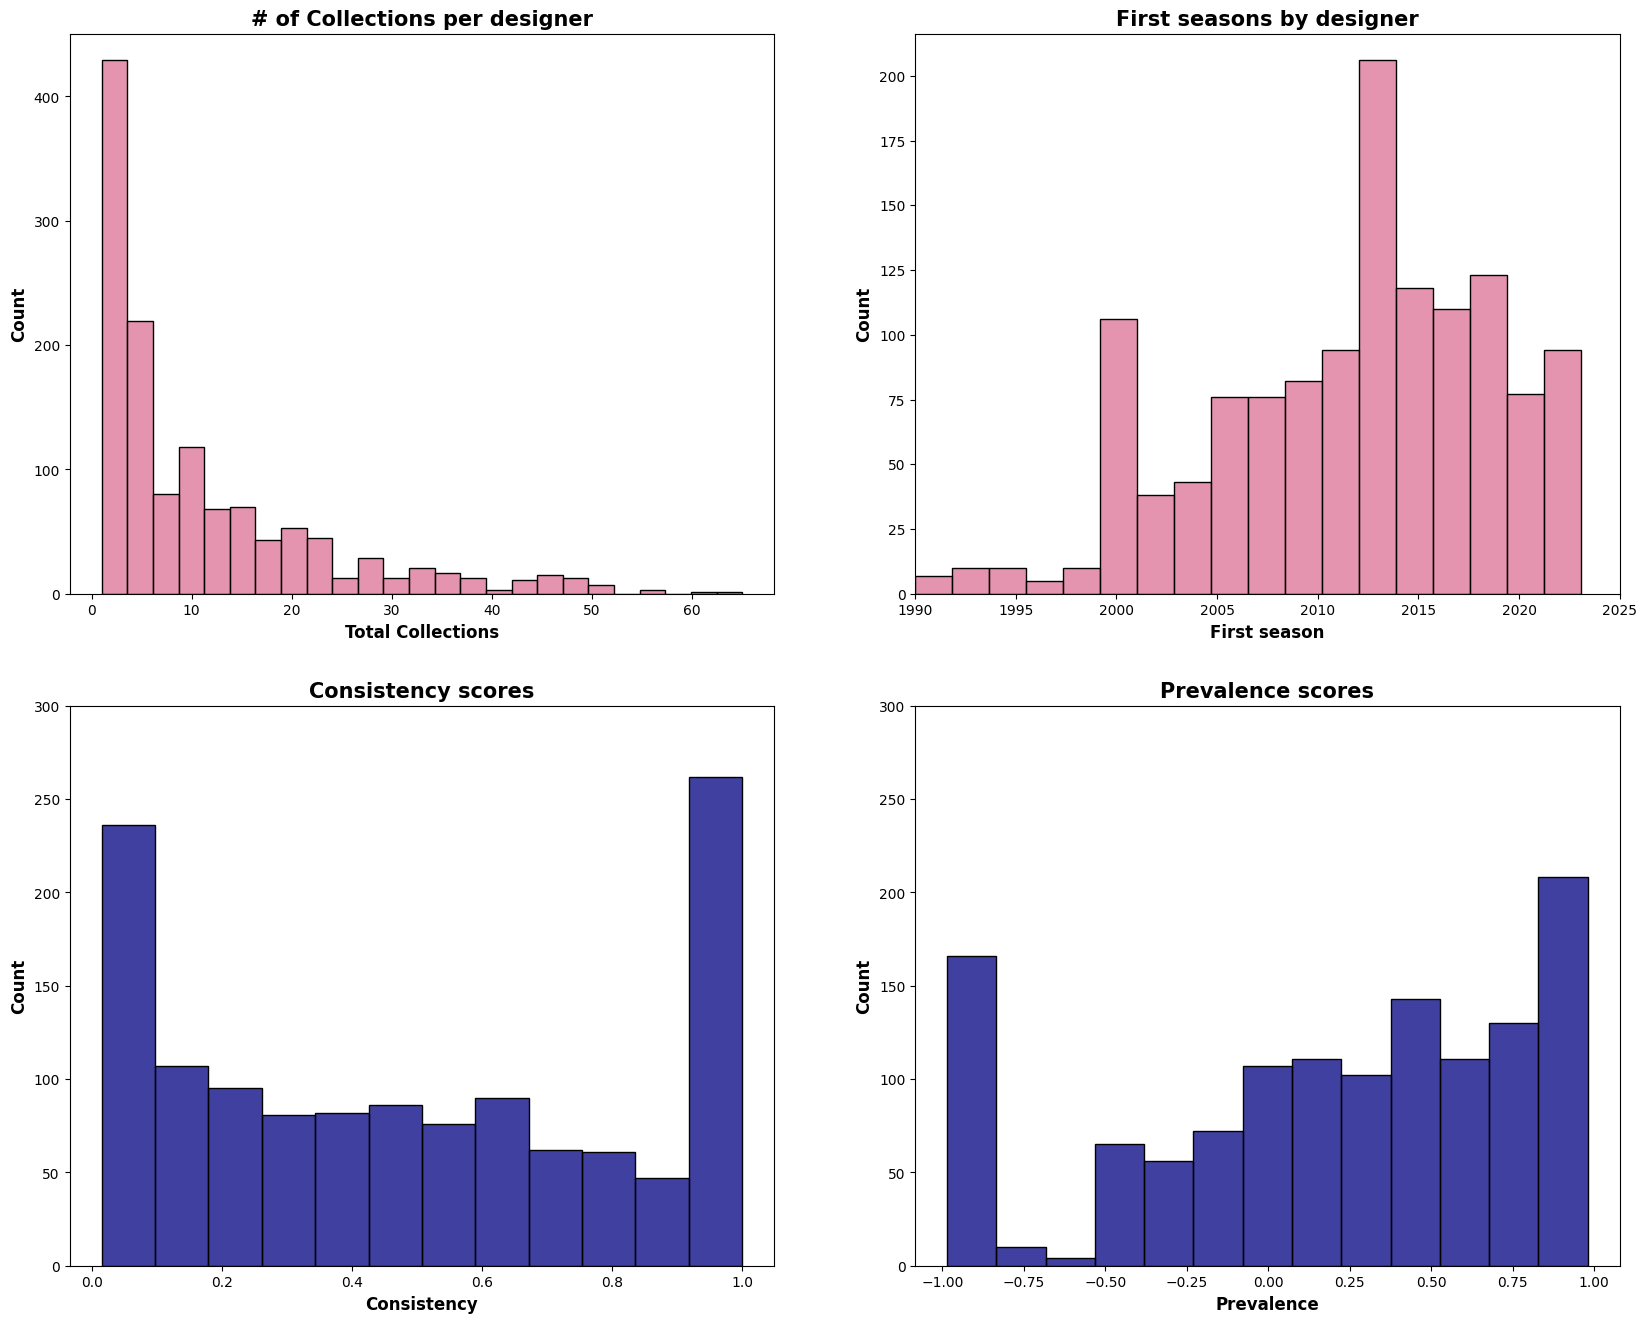

In [32]:
# plot the distributions of classes, collections, and first seasons
fig, ax = plt.subplots(2, 2, figsize=(20, 16))

# distribution of total collections
sns.histplot(data=designers,color = 'palevioletred', x = 'collections', bins="auto", ax = ax[0,0])
ax[0,0].set_title('# of Collections per designer', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[0,0].set_xlabel('Total Collections', fontsize = 12, fontweight='bold') 
ax[0,0].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# distribution of initial seasons 
sns.histplot(data=designers, color = 'palevioletred',x = 'first_season', ax = ax[0,1])
ax[0,1].set_xlim(1990,2025)
ax[0,1].set_title('First seasons by designer', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[0,1].set_xlabel('First season', fontsize = 12, fontweight='bold') 
ax[0,1].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# distribution of prevalance scores 
sns.histplot(data=designers, color = 'navy', x = 'prevalence', bins="auto", ax = ax[1,1])
ax[1,1].set_title('Prevalence scores', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[1,1].set_xlabel('Prevalence', fontsize = 12, fontweight='bold') 
ax[1,1].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# distribution of consistency scores 
sns.histplot(data=designers,color ='navy', x = 'consistency', bins="auto", ax = ax[1,0])
ax[1,0].set_title('Consistency scores', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[1,0].set_xlabel('Consistency', fontsize = 12, fontweight='bold') 
ax[1,0].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# Set the same y-axis limits for bottom two plots
ax[1,0].set_ylim(0, 300)
ax[1,1].set_ylim(0, 300)

plt.show()

In [33]:
from nltk.tokenize import word_tokenize
preprocessed = [sentence for sentence in collections['preprocessed_sentences']]
collections['tokens'] = [word_tokenize(sentence) for sentence in preprocessed]

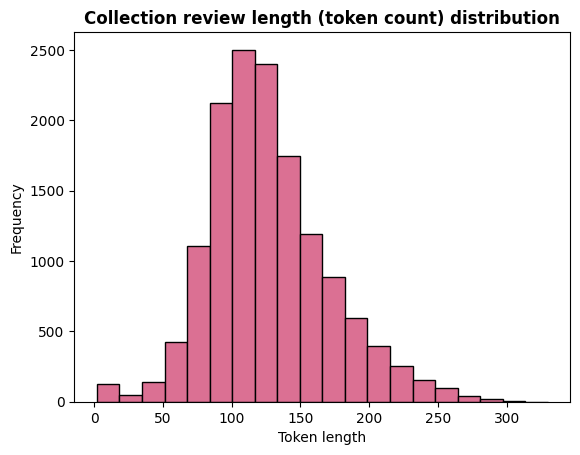

In [34]:
# plot the token length distribution using pandas

collections['tokens'].apply(len).hist(bins=20, edgecolor = 'black', color='palevioletred')
plt.title('Collection review length (token count) distribution',fontdict = {'fontsize': 12, 'fontweight':'bold'})
plt.xlabel('Token length')
plt.grid(False)
plt.ylabel('Frequency')
plt.show()

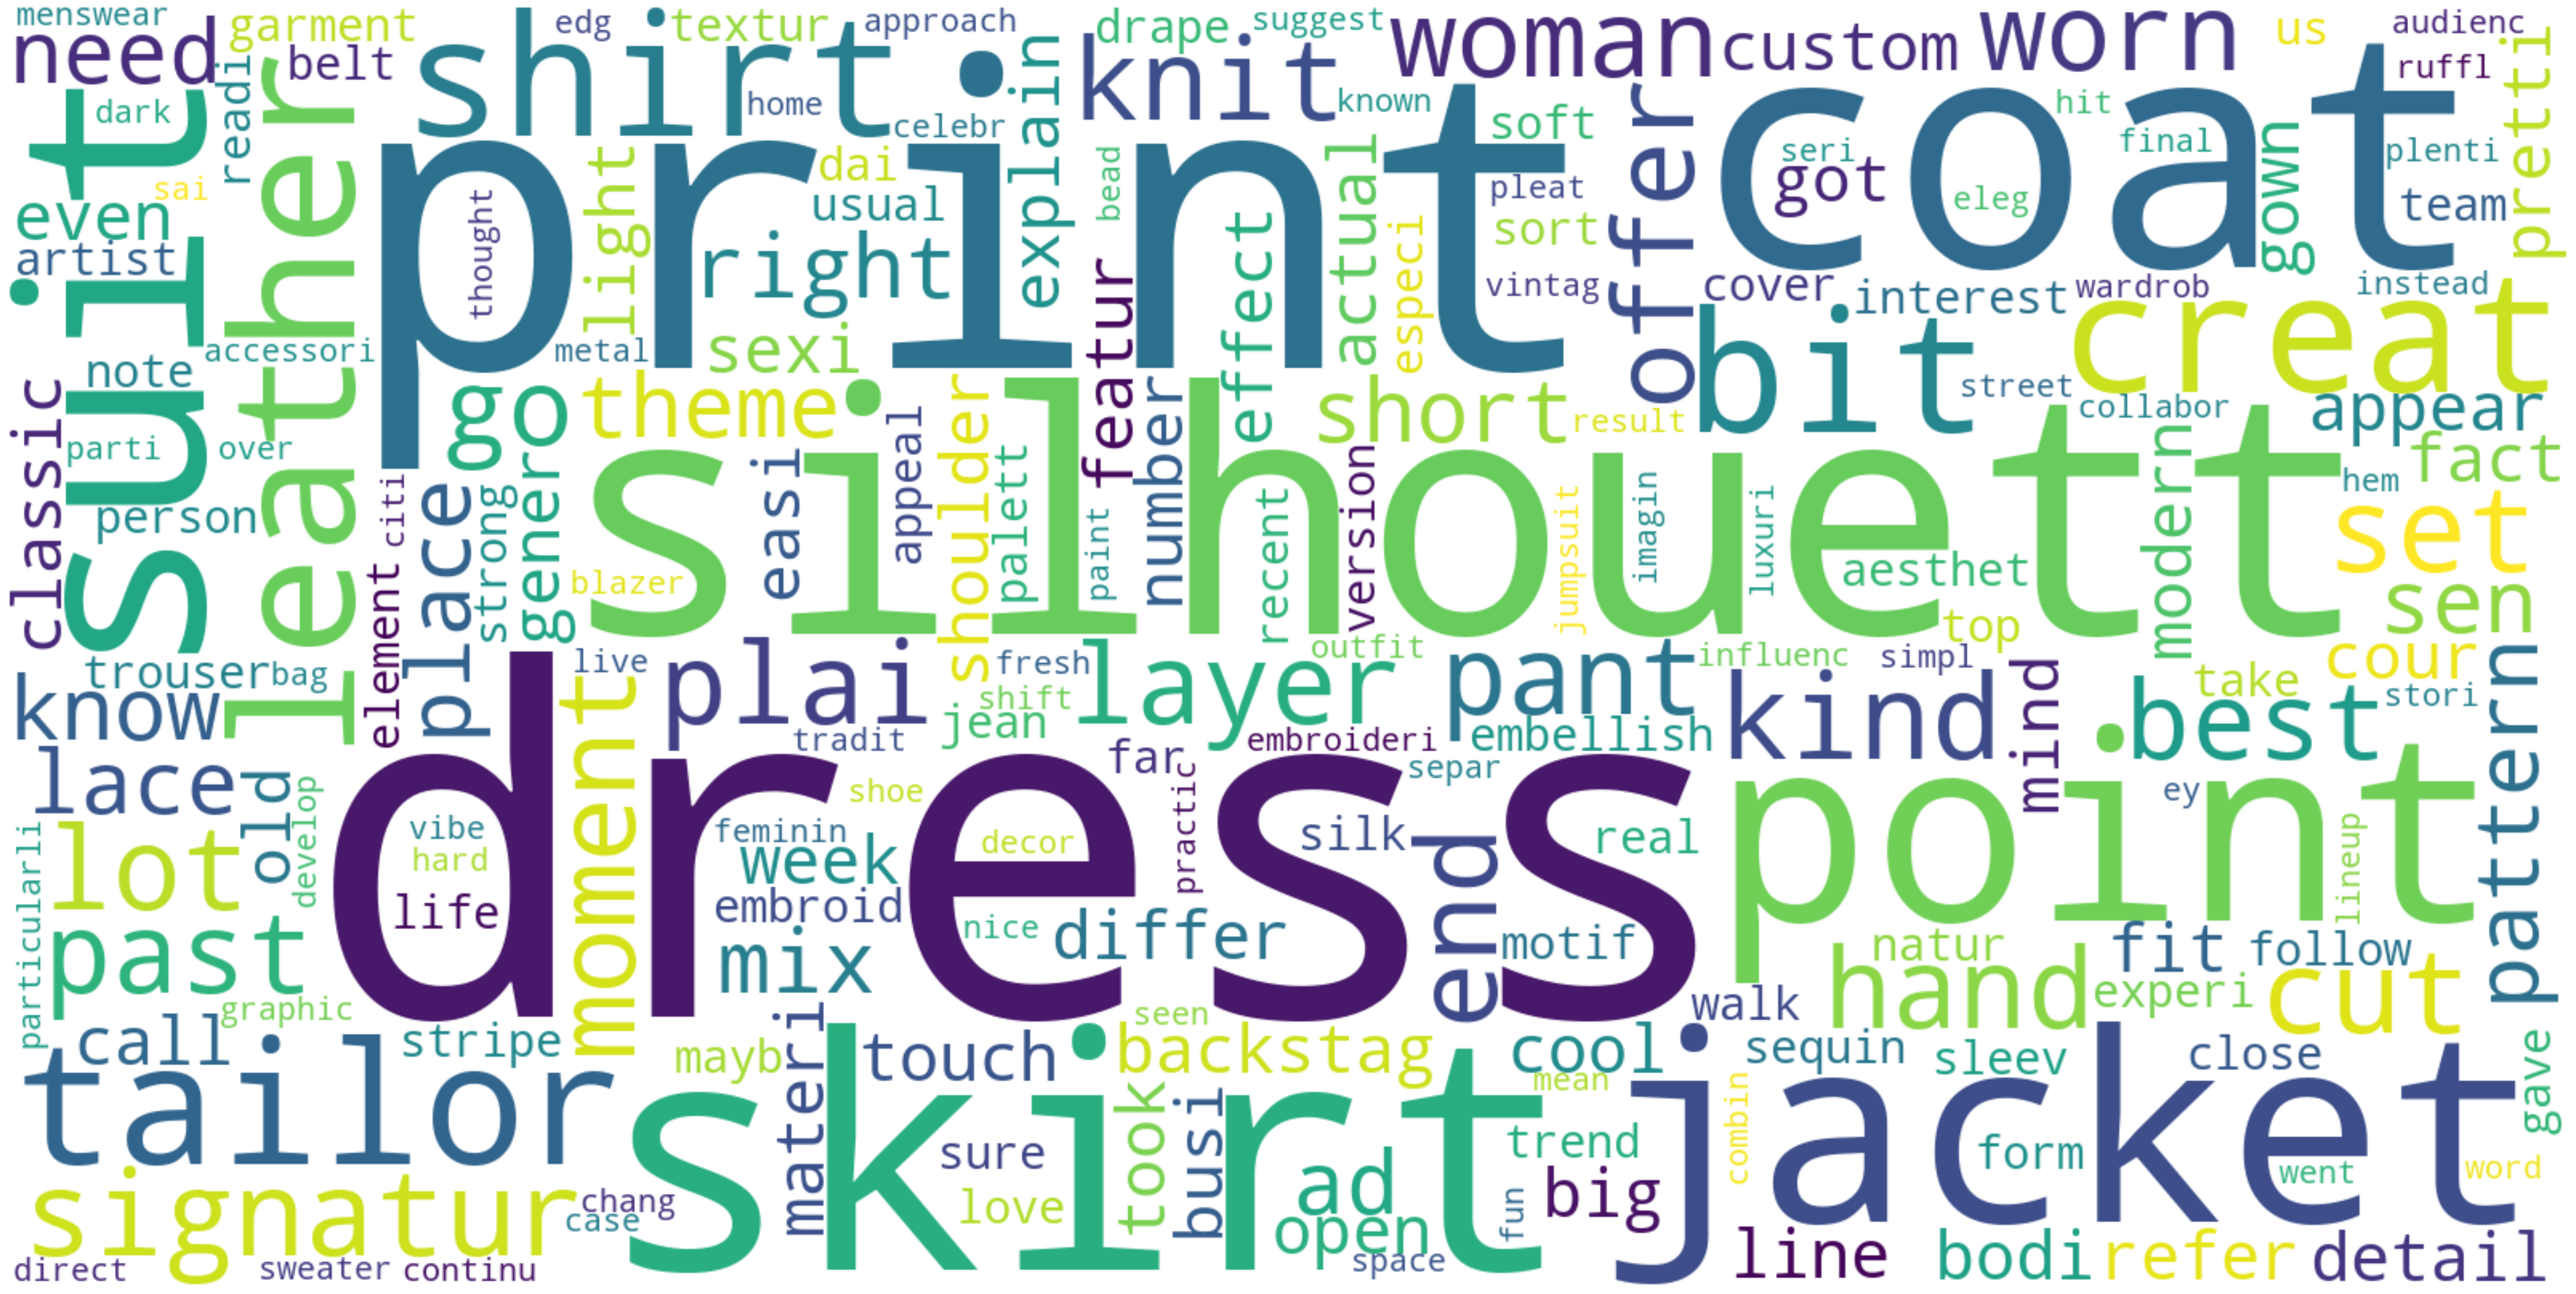

In [35]:
from wordcloud import WordCloud
stopwords = ['season','wai','good','pair','year','felt','focu','start','make', 'look','men','littl','present','fabric','girl','shape','includ', 'collect', 'show','wear','women','runwai','model', 'think','color','want','feel', 'inspir','come', 'fall','spring', 'work', 'show','like', 'todai','came','thing', 'look','design','cloth','piec','time','work','said','style','idea','turn']
wc = WordCloud(stopwords = stopwords, background_color="white", max_font_size= 300,  width=1600, height=800).generate(' '.join(sample_tokens['tokens']))

plt.figure(figsize=(50,30))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [36]:
# create a word frequency dataframe
term_frequency = (sample_tokens
                  .groupby(by=['id', 'tokens'])
                  .agg({'tokens': 'count'})
                  .rename(columns={'tokens': 'term_frequency'})
                  .reset_index()
                  .rename(columns={'tokens': 'term'})
                 )

term_frequency.sort_values('term_frequency', ascending = False)[25:40]

,id,term,term_frequency
1411946,12838,monogram,10
1606517,14207,hors,10
721509,7460,wool,10
1612399,14247,alien,10
1547315,13798,merhej,10
1587192,14070,heart,10
889132,8855,look,10
1114134,10619,dough,10
1053990,10146,like,10
1558832,13880,embroid,10


In [37]:
# Document Frequency
document_frequency = (term_frequency
                      .groupby(['id', 'term'])
                      .size()
                      .unstack()
                      .sum()
                      .reset_index()
                      .rename(columns={0: 'document_frequency'})
                     )

# merge dataframes
term_frequency = term_frequency.merge(document_frequency)

documents_in_corpus = term_frequency['id'].nunique()

term_frequency['idf'] = np.log((1 + documents_in_corpus) / (1 + term_frequency['document_frequency'])) + 1
term_frequency['tfidf'] = term_frequency['term_frequency'] * term_frequency['idf']

In [38]:
from sklearn import preprocessing
term_frequency['tfidf_norm'] = preprocessing.normalize(term_frequency[['tfidf']], axis=0, norm='l2')
term_frequency.sort_values(by=['tfidf_norm'], ascending=[False]).groupby(['term']).head()

,id,term,term_frequency,document_frequency,idf,tfidf,tfidf_norm
1613977,14031,abijako,14,1.0,9.872207,138.210895,0.020064
639426,7076,review,19,179.0,5.372397,102.075545,0.014818
1611773,13296,linnetz,11,5.0,8.773594,96.509539,0.014010
1606861,10619,dough,10,2.0,9.466742,94.667416,0.013743
1612745,13283,yadda,9,1.0,9.872207,88.849861,0.012898
...,...,...,...,...,...,...,...
1424557,718,conjur,1,347.0,4.713151,4.713151,0.000684
461713,242,accessor,1,357.0,4.684821,4.684821,0.000680
461715,334,accessor,1,357.0,4.684821,4.684821,0.000680
956397,6406,strongest,1,363.0,4.668200,4.668200,0.000678


### Fitting a Naive Bayes classifier to evaluate word significance and predict class of designer based on collection description
Using the collections dataframe, we use a supervised learning algorithm to classify the designer collections.

In [165]:
# check for seasons that only have one datapoint

collections['designer'].value_counts()

designer
comme-des-garcons    65
versace              61
prada                57
alexander-mcqueen    57
miu-miu              55
                     ..
joy-cioci             1
jayson-brunsdon       1
lala-berlin           1
laurel                1
marco-rambaldi        1
Name: count, Length: 1285, dtype: int64

In [162]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize, WhitespaceTokenizer, TweetTokenizer

subset = collections[collections['designer']>1990.1]

X = subset['preprocessed_sentences']
y = subset['designer']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [163]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_test_le = label_encoder.transform(y_test)

print(f'Label encoded training labels shape: {y_train_le.shape}')
print(f'Label encoded validation labels shape: {y_test_le.shape}')

Label encoded training labels shape: (10693,)
Label encoded validation labels shape: (3565,)


In [164]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
X_train = cv.fit_transform(X_train.values)
X_test = cv.transform(X_test.values)

nb_model =  MultinomialNB()
nb_model.fit(X_train, y_train_le)

# Predict the authors of validation dataset
nb_predictions = nb_model.predict(X_test)

print(nb_model.score(X_test, y_test_le))

0.13071528751753156


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))